#### 0) Packages and Functions

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf
from scipy.optimize import curve_fit
import scipy.signal
from scipy.signal.windows import gaussian as windows_gaussian
scipy.signal.gaussian = windows_gaussian
import pymc as pm
import pytensor.tensor as pt
from pytensor import scan, function
import arviz as az
import warnings

In [103]:
warnings.filterwarnings('ignore')

#### 1) Functions

In [142]:
def compute_ema(series, decay):
    """
    Compute the Exponential Moving Average (EMA) of a time series.
    
    The smoothing factor is computed as:
        alpha = 1 - decay

    Parameters
    ----------
    series : pandas.Series
        The input time series data.
    decay : float
        The decay parameter, where 0 < decay < 1.

    Returns
    -------
    ema : pandas.Series
        The exponential moving average of the input series.
    """
    return series.ewm(alpha=1-decay, adjust=False).mean()

def power_func(x, alpha, gamma):
    """
    Apply a power transformation to the input.

    The transformation is defined as:
        S(x) = gamma * x^alpha

    Parameters
    ----------
    x : array-like or scalar
        The input values.
    alpha : float
        The exponent applied to x.
    gamma : float
        The scaling factor.

    Returns
    -------
    transformed : array-like or scalar
        The transformed values.
    """
    return gamma * (x ** alpha)

def adstock(spend, decay):
    """
    Compute the adstock transformation for an advertising spend series.
    
    The adstock effect is defined recursively:
        y[0] = spend[0]
        y[t] = spend[t] + decay * y[t-1]  for t >= 1

    Parameters
    ----------
    spend : array-like
        The sequence of advertising spend values.
    decay : float
        The decay factor (typically between 0 and 1) that governs how past spend is carried forward.

    Returns
    -------
    adstocked : pytensor.tensor.TensorVariable
        The adstock-transformed spend series as a symbolic PyTensor object.
    """
    spend_sym = pt.as_tensor_variable(spend)
    
    def recurrence(x, y_prev, d):
        return x + d * y_prev

    results, updates = scan(fn=recurrence,
                            sequences=spend_sym[1:],
                            outputs_info=spend_sym[0],
                            non_sequences=[decay])
    
    return pt.concatenate([pt.stack([spend_sym[0]]), results])

def beta_params_from_mode(mode, concentration=4):
    """
    Calculate the parameters (alpha, beta) of a Beta distribution 
    given a desired mode and a total concentration (alpha + beta).
    
    The Beta distribution is defined on [0, 1] and its mode is given by:
        mode = (alpha - 1) / (alpha + beta - 2)
    
    To solve for alpha and beta, we choose a total concentration K = alpha + beta (K > 2).
    Then:
        alpha = 1 + mode * (K - 2)
        beta = K - alpha = K - 1 - mode * (K - 2)
    
    Parameters
    ----------
    mode : float
        The desired mode of the Beta distribution (must be between 0 and 1).
    concentration : float, optional
        The sum of the shape parameters (alpha + beta). Must be greater than 2.
        A higher concentration implies the prior is more concentrated (less variance)
        around the mode. Default is 4.
    
    Returns
    -------
    alpha : float
        The calculated alpha parameter.
    beta : float
        The calculated beta parameter.
    
    Raises
    ------
    ValueError
        If the concentration is less than or equal to 2 or if the mode is not between 0 and 1.
    """
    if not (0 < mode < 1):
        raise ValueError("Mode must be between 0 and 1.")
    if concentration <= 2:
        raise ValueError("Concentration (alpha + beta) must be greater than 2.")
    
    alpha = 1 + mode * (concentration - 2)
    beta = concentration - alpha
    return alpha, beta

#### 2) Parameters

In [105]:
np.random.seed(42)

In [106]:
input_filepath = 'C:\\Users\\rbush\\MMM Sample Dataset.csv'

#### 3) EDA and Prior Calculation

In [107]:
data = pd.read_csv(input_filepath)

In [108]:
data['Date'] = pd.to_datetime(data['Date'])

In [109]:
data.head(10)

,Date,TV,Radio,Banners,Sales
0,2018-01-07,13528.10,0.00,0.00,9779.80
1,2018-01-14,0.00,5349.65,2218.93,13245.19
2,2018-01-21,0.00,4235.86,2046.96,12022.66
3,2018-01-28,0.00,3562.21,0.00,8846.95
4,2018-02-04,0.00,0.00,2187.29,9797.07
5,2018-02-11,8045.44,4310.55,1992.98,13527.65
6,2018-02-18,0.00,0.00,2253.02,9635.43
7,2018-02-25,9697.29,4478.81,2042.30,15355.11
8,2018-03-04,0.00,3156.93,1859.02,12199.37
9,2018-03-11,0.00,4522.03,2135.99,11368.23


##### Baseline and Channel Sales

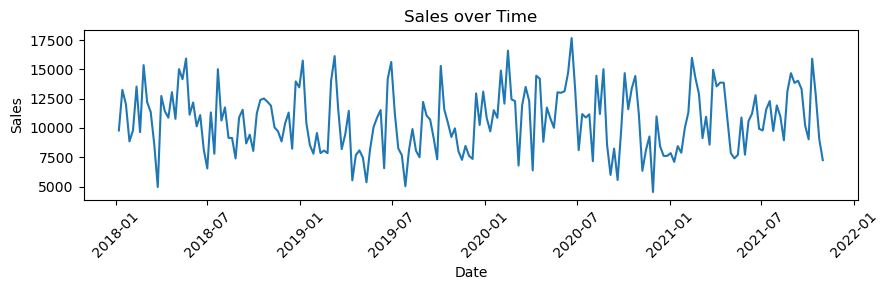

In [110]:
# TV Spend vs Sales
plt.figure(figsize=(9, 3))
sns.lineplot(x='Date', y='Sales', data=data)
plt.title("Sales over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [111]:
sales_obs = data['Sales'].values.astype('float64')
sales_std = np.std(sales_obs)
print("Sample sales standard deviation:", round(sales_std))

Sample sales standard deviation: 2694


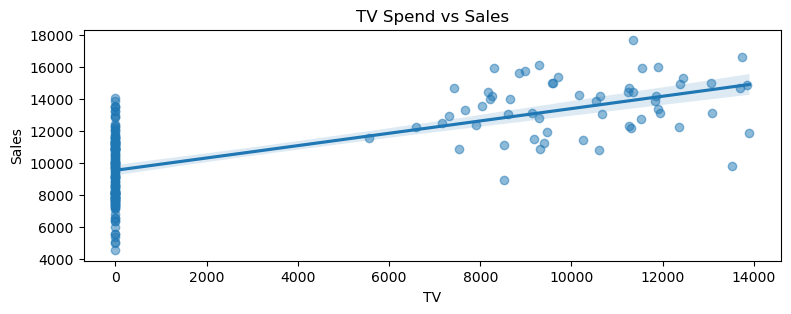

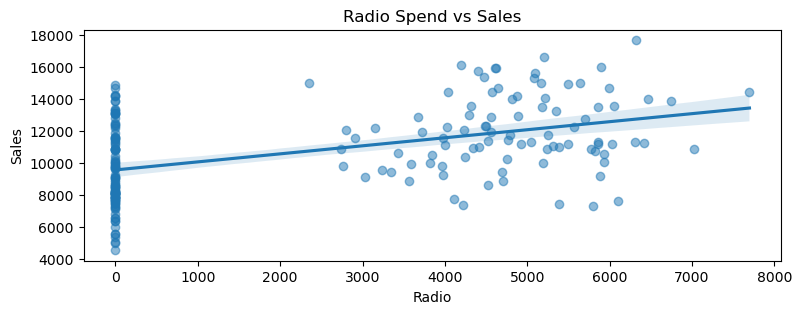

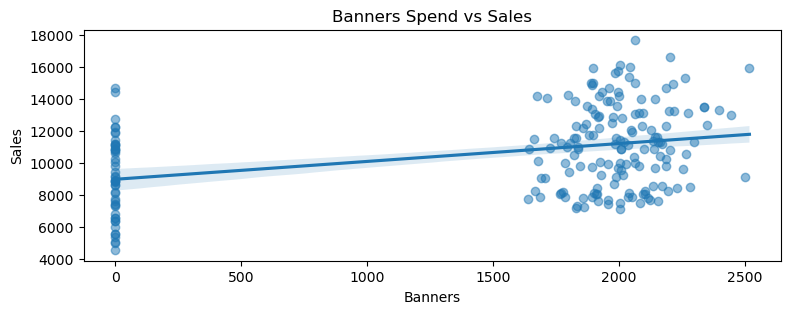

In [112]:
# TV Spend vs Sales
plt.figure(figsize=(9, 3))
sns.regplot(x='TV', y='Sales', data=data, scatter_kws={'alpha':0.5})
plt.title("TV Spend vs Sales")
plt.show()

# Radio Spend vs Sales
plt.figure(figsize=(9, 3))
sns.regplot(x='Radio', y='Sales', data=data, scatter_kws={'alpha':0.5})
plt.title("Radio Spend vs Sales")
plt.show()

# Banners Spend vs Sales
plt.figure(figsize=(9, 3))
sns.regplot(x='Banners', y='Sales', data=data, scatter_kws={'alpha':0.5})
plt.title("Banners Spend vs Sales")
plt.show()

In [113]:
X = data[['TV', 'Radio', 'Banners']]
X = sm.add_constant(X)  # adds the intercept term
y = data['Sales']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     234.8
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           1.28e-64
Time:                        16:45:37   Log-Likelihood:                -1711.1
No. Observations:                 200   AIC:                             3430.
Df Residuals:                     196   BIC:                             3443.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6678.3969    209.575     31.866      0.0

In [114]:
# Store informed priors for baseline and channel mu
mu0_baseline = model.params['const']
mu0_tv = model.params['TV']
mu0_radio = model.params['Radio']
mu0_banners = model.params['Banners']

# Store informed priors for baseline and channel sigma
sigma0_baseline = model.bse['const']
sigma0_tv = 1
sigma0_radio = 1
sigma0_banners = 1

In [115]:
# Print out the values
print("Informed Priors for Coefficients (mu):")
print(f"Baseline: {mu0_baseline:.4f}")
print(f"TV: {mu0_tv:.4f}")
print(f"Radio: {mu0_radio:.4f}")
print(f"Banners: {mu0_banners:.4f}\n")

print("Informed Priors for Standard Errors (sigma):")
print(f"Baseline: {sigma0_baseline:.4f}")
print(f"TV: {sigma0_tv:.4f}")
print(f"Radio: {sigma0_radio:.4f}")
print(f"Banners: {sigma0_banners:.4f}")

Informed Priors for Coefficients (mu):
Baseline: 6678.3969
TV: 0.3597
Radio: 0.4883
Banners: 1.2159

Informed Priors for Standard Errors (sigma):
Baseline: 209.5746
TV: 1.0000
Radio: 1.0000
Banners: 1.0000


##### Ad-stock Decay

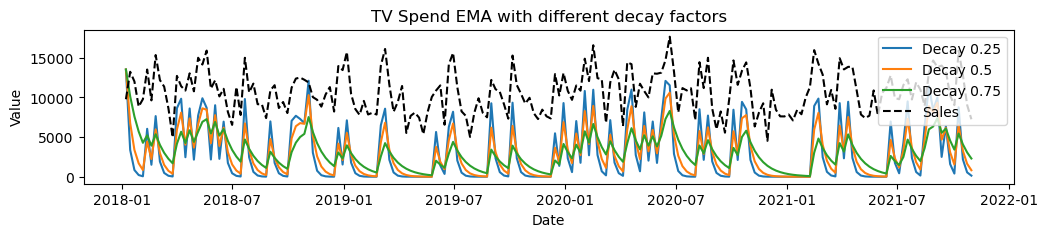

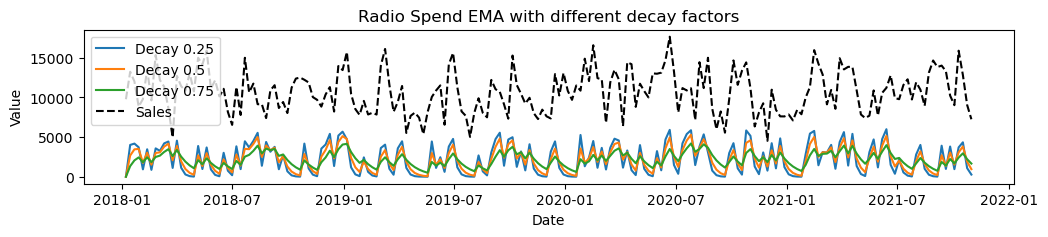

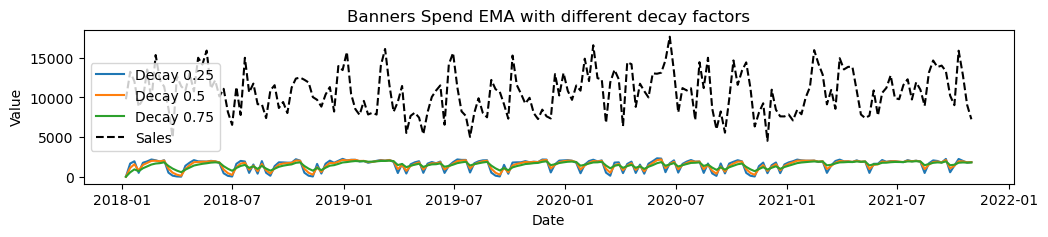

In [116]:
# Parameters
decay_parameters = [0.25,0.5,0.75]
figure_size = (12,2)

# Ad-stock Decay for TV
plt.figure(figsize=figure_size)

# Try a few decay factors
for decay in decay_parameters:
    data[f'TV_ema_{decay}'] = compute_ema(data['TV'], decay)
    plt.plot(data['Date'], data[f'TV_ema_{decay}'], label=f'Decay {decay}')

plt.plot(data['Date'], data['Sales'], 'k--', label='Sales')
plt.title("TV Spend EMA with different decay factors")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Ad-stock Decay for Radio
plt.figure(figsize=figure_size)

# Try a few decay factors
for decay in decay_parameters:
    data[f'Radio_ema_{decay}'] = compute_ema(data['Radio'], decay)
    plt.plot(data['Date'], data[f'Radio_ema_{decay}'], label=f'Decay {decay}')

plt.plot(data['Date'], data['Sales'], 'k--', label='Sales')
plt.title("Radio Spend EMA with different decay factors")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Ad-stock Decay for Banners
plt.figure(figsize=figure_size)

# Try a few decay factors
for decay in decay_parameters:
    data[f'Banners_ema_{decay}'] = compute_ema(data['Banners'], decay)
    plt.plot(data['Date'], data[f'Banners_ema_{decay}'], label=f'Decay {decay}')

plt.plot(data['Date'], data['Sales'], 'k--', label='Sales')
plt.title("Banners Spend EMA with different decay factors")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

In [117]:
#   In the previous exercise, I identified optimal Ad-stock decay parameters with a simple linear regression.  Those values were:
#    - TV: 0.4
#    - Radio: 0.5
#    - Banners: 0.2
#   I'll re-use these parameters as informed priors here for simplicity.  We'll estimate the ad-stock decay parameter with a Beta distribution, 
#   as it falls between 0 and 1.
tv_decay = 0.4
radio_decay = 0.5
banners_decay = 0.2

alpha_decay_tv0, beta_decay_tv0 = beta_params_from_mode(mode=tv_decay)
alpha_decay_radio0, beta_decay_radio0 = beta_params_from_mode(mode=radio_decay)
alpha_decay_banners0, beta_decay_banners0 = beta_params_from_mode(mode=banners_decay)

In [118]:
# Print out the computed Beta parameters using formatted strings
print(f"TV Decay Prior Parameters (decay = {tv_decay}): alpha = {alpha_decay_tv0:.2f}, beta = {beta_decay_tv0:.2f}")
print(f"Radio Decay Prior Parameters (decay = {radio_decay}): alpha = {alpha_decay_radio0:.2f}, beta = {beta_decay_radio0:.2f}")
print(f"Banners Decay Prior Parameters (decay = {banners_decay}): alpha = {alpha_decay_banners0:.2f}, beta = {beta_decay_banners0:.2f}")

TV Decay Prior Parameters (decay = 0.4): alpha = 1.80, beta = 2.20
Radio Decay Prior Parameters (decay = 0.5): alpha = 2.00, beta = 2.00
Banners Decay Prior Parameters (decay = 0.2): alpha = 1.40, beta = 2.60


##### Saturation

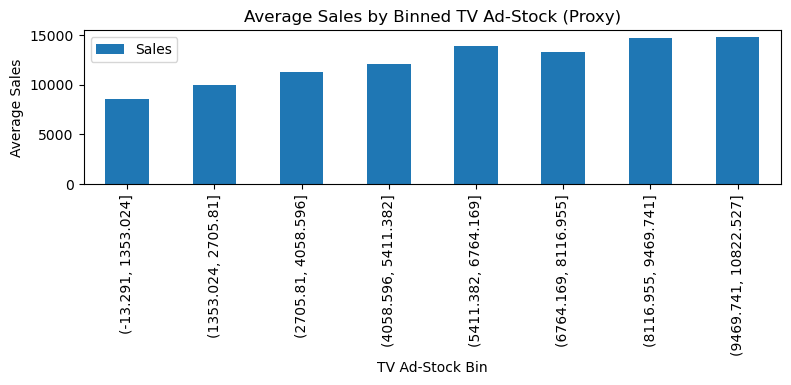

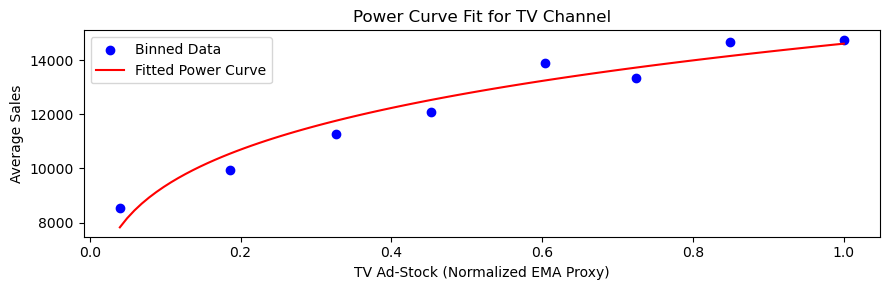

Estimated saturation parameter (alpha): 0.1936168147451473
Estimated scaling parameter (gamma): 14610.658793853672


In [119]:
# Assume a decay value of 0.5 for the prior calculation
data['TV_adstock'] = compute_ema(series=data['TV'], decay=0.5)

# Bin the TV_adstock values into 10 bins.
data['TV_adstock_bin'] = pd.cut(data['TV_adstock'], bins=10)

# Group by the binned intervals and aggregate both the mean TV_adstock and mean Sales.
binned = data.groupby('TV_adstock_bin').agg({'TV_adstock': 'mean', 'Sales': 'mean'}).dropna()
binned = binned.iloc[:-1]

# Normalize TV_adstock to avoid numerical issues
binned['TV_adstock_norm'] = binned['TV_adstock'] / binned['TV_adstock'].max()

# Use improved initial guesses
initial_guesses = (0.5, 10000)  # Alpha ~ moderate power, Gamma ~ expected sales

# Fit the function
popt, pcov = curve_fit(
    power_func,
    binned['TV_adstock_norm'],  # Use normalized values for better fitting
    binned['Sales'],
    p0=initial_guesses,
    bounds=([0.01, 500], [2, 20000])  # Alpha between 0.01 and 2, Gamma flexible
)

alpha_est, gamma_est = popt

# Generate x values for plotting
x_vals = np.linspace(binned['TV_adstock_norm'].min(), binned['TV_adstock_norm'].max(), 100)

# Plot the binned data as a bar chart.
binned.plot(kind='bar', y='Sales', figsize=(9, 2))
plt.title("Average Sales by Binned TV Ad-Stock (Proxy)")
plt.xlabel("TV Ad-Stock Bin")
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()

# Plot the data and fitted curve
plt.figure(figsize=(9, 3))
plt.scatter(binned['TV_adstock_norm'], binned['Sales'], label="Binned Data", color="blue")
plt.plot(x_vals, power_func(x_vals, alpha_est, gamma_est), label="Fitted Power Curve", color="red")
plt.xlabel("TV Ad-Stock (Normalized EMA Proxy)")
plt.ylabel("Average Sales")
plt.title("Power Curve Fit for TV Channel")
plt.legend()
plt.tight_layout()
plt.show()

alpha_sat_tv0 = alpha_est
gamma_sat_tv0 = gamma_est

print("Estimated saturation parameter (alpha):", alpha_est)
print("Estimated scaling parameter (gamma):", gamma_est)

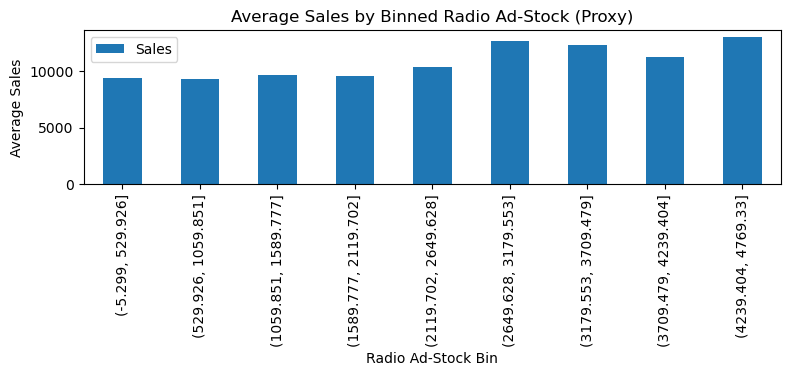

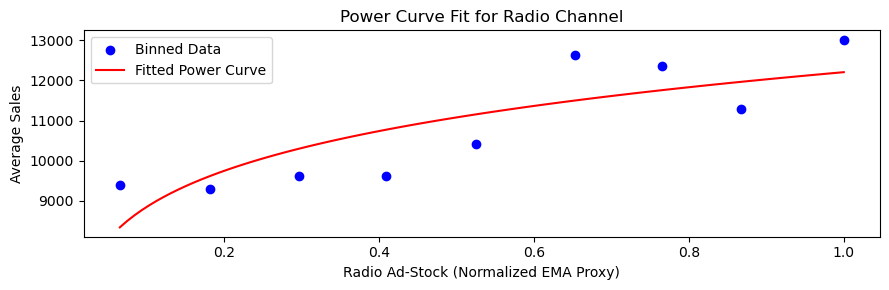

Estimated power parameter (alpha): 0.13977079606620033
Estimated scaling parameter (gamma): 12205.931180850566


In [120]:
# Assume a decay value of 0.5 for the prior calculation
data['Radio_adstock'] = compute_ema(series=data['Radio'], decay=0.5)

# Bin the Radio_adstock values into 10 bins
data['Radio_adstock_bin'] = pd.cut(data['Radio_adstock'], bins=10)

# Group by the binned intervals and aggregate both the mean Radio_adstock and mean Sales
binned = data.groupby('Radio_adstock_bin').agg({'Radio_adstock': 'mean', 'Sales': 'mean'}).dropna()
binned = binned.iloc[:-1]  # Drop the last bin to avoid potential NaN issues

# Normalize Radio_adstock to avoid numerical issues
binned['Radio_adstock_norm'] = binned['Radio_adstock'] / binned['Radio_adstock'].max()

# Use improved initial guesses
initial_guesses = (0.5, 10000)  # Alpha ~ moderate power, Gamma ~ expected sales

# Fit the function
popt, pcov = curve_fit(
    power_func,
    binned['Radio_adstock_norm'],  # Use normalized values for better fitting
    binned['Sales'],
    p0=initial_guesses,
    bounds=([0.01, 500], [2, 20000])  # Alpha between 0.01 and 2, Gamma flexible
)

alpha_est, gamma_est = popt

# Generate x values for plotting
x_vals = np.linspace(binned['Radio_adstock_norm'].min(), binned['Radio_adstock_norm'].max(), 100)

# Plot the binned data as a bar chart
binned.plot(kind='bar', y='Sales', figsize=(9, 2))
plt.title("Average Sales by Binned Radio Ad-Stock (Proxy)")
plt.xlabel("Radio Ad-Stock Bin")
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()

# Plot the data and fitted curve
plt.figure(figsize=(9, 3))
plt.scatter(binned['Radio_adstock_norm'], binned['Sales'], label="Binned Data", color="blue")
plt.plot(x_vals, power_func(x_vals, alpha_est, gamma_est), label="Fitted Power Curve", color="red")
plt.xlabel("Radio Ad-Stock (Normalized EMA Proxy)")
plt.ylabel("Average Sales")
plt.title("Power Curve Fit for Radio Channel")
plt.legend()
plt.tight_layout()
plt.show()

alpha_sat_radio0 = alpha_est
gamma_sat_radio0 = gamma_est

print("Estimated power parameter (alpha):", alpha_est)
print("Estimated scaling parameter (gamma):", gamma_est)

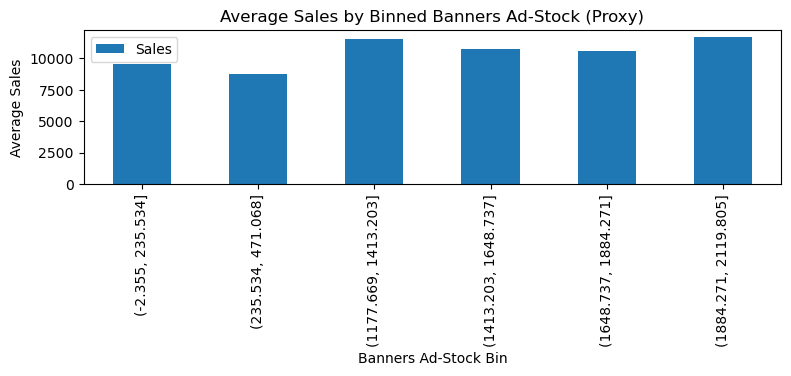

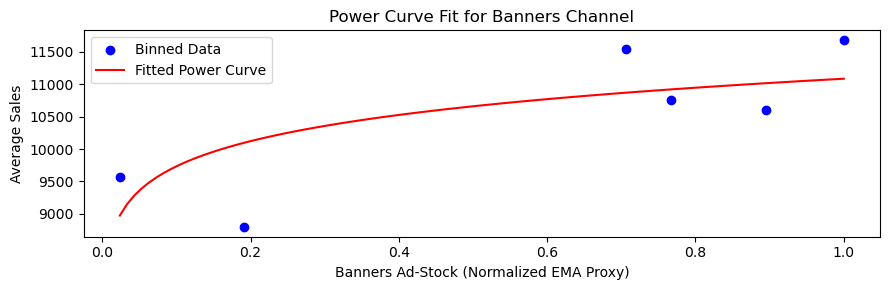

Estimated power parameter (alpha): 0.056515901063168235
Estimated scaling parameter (gamma): 11085.506378167023


In [121]:
# Assume a decay value of 0.2 for the prior calculation
data['Banners_adstock'] = compute_ema(series=data['Banners'], decay=0.2)

# Bin the Banners_adstock values into 10 bins
data['Banners_adstock_bin'] = pd.cut(data['Banners_adstock'], bins=10)

# Group by the binned intervals and aggregate both the mean Banners_adstock and mean Sales
binned = data.groupby('Banners_adstock_bin').agg({'Banners_adstock': 'mean', 'Sales': 'mean'}).dropna()
binned = binned.iloc[:-1]  # Drop the last bin to avoid potential NaN issues

# Normalize Banners_adstock to avoid numerical issues
binned['Banners_adstock_norm'] = binned['Banners_adstock'] / binned['Banners_adstock'].max()

# Use improved initial guesses
initial_guesses = (0.5, 10000)  # Alpha ~ moderate power, Gamma ~ expected sales

# Fit the function
popt, pcov = curve_fit(
    power_func,
    binned['Banners_adstock_norm'],  # Use normalized values for better fitting
    binned['Sales'],
    p0=initial_guesses,
    bounds=([0.01, 500], [2, 20000])  # Alpha between 0.01 and 2, Gamma flexible
)

alpha_est, gamma_est = popt

# Generate x values for plotting
x_vals = np.linspace(binned['Banners_adstock_norm'].min(), binned['Banners_adstock_norm'].max(), 100)

# Plot the binned data as a bar chart
binned.plot(kind='bar', y='Sales', figsize=(9, 2))
plt.title("Average Sales by Binned Banners Ad-Stock (Proxy)")
plt.xlabel("Banners Ad-Stock Bin")
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()

# Plot the data and fitted curve
plt.figure(figsize=(9, 3))
plt.scatter(binned['Banners_adstock_norm'], binned['Sales'], label="Binned Data", color="blue")
plt.plot(x_vals, power_func(x_vals, alpha_est, gamma_est), label="Fitted Power Curve", color="red")
plt.xlabel("Banners Ad-Stock (Normalized EMA Proxy)")
plt.ylabel("Average Sales")
plt.title("Power Curve Fit for Banners Channel")
plt.legend()
plt.tight_layout()
plt.show()

alpha_sat_banners0 = alpha_est
gamma_sat_banners0 = gamma_est

print("Estimated power parameter (alpha):", alpha_est)
print("Estimated scaling parameter (gamma):", gamma_est)

In [122]:
# Print out the computed saturation parameters using formatted strings
print(f"TV Saturation Prior Parameters: alpha = {alpha_sat_tv0:.2f}, gamma = {gamma_sat_tv0:.2f}")
print(f"Radio Saturation Prior Parameters: alpha = {alpha_sat_radio0:.2f}, gamma = {gamma_sat_radio0:.2f}")
print(f"Banners Saturation Prior Parameters: alpha = {alpha_sat_banners0:.2f}, gamma = {gamma_sat_banners0:.2f}")

TV Saturation Prior Parameters: alpha = 0.19, gamma = 14610.66
Radio Saturation Prior Parameters: alpha = 0.14, gamma = 12205.93
Banners Saturation Prior Parameters: alpha = 0.06, gamma = 11085.51


#### 4) Fit the Bayesian MMM

I have estimates for priors for just about everything, but I still need some ballpark estimates for my half-normal saturation parameters, as well as the standard deviation value in my gamma normal distributions:
<ul>
    <li>For my half-normal saturation parameter, I'm selecting a sigma of 1.  Since all of my alphas are less than 0.2, the density of parameter search around the values I expect them to be should be pretty reasonable while avoiding being too strong.</li>
    <li>For the normal gamma distribution, I am using the gamma values calculated above for my mu priors.  I will use a sigma value of 10,000 to search fairly broadly in the space I expect the parameter mean to fall.</li>
</ul>
Additionally, I want to add a margin to my starting point to ensure that my model does not underfit the training data:
<ul>
    <li>I will add a margin of 5000 to the saturation gamma mean to ensure if anything we overshoot.</li>
</ul>

In [123]:
sat_alpha_sigma_prior = 1
sat_gamma_mean_margin = 5000
sat_gamma_sigma_prior = 10000

In [124]:
with pm.Model() as mmm_model:
    
    # 1. Priors for the intercept and channel coefficients
    intercept = pm.Normal('intercept', mu=mu0_baseline, sigma=sigma0_baseline)
    beta_tv = pm.Normal('beta_tv', mu=mu0_tv, sigma=sigma0_tv)
    beta_radio = pm.Normal('beta_radio', mu=mu0_radio, sigma=sigma0_radio)
    beta_banners = pm.Normal('beta_banners', mu=mu0_banners, sigma=sigma0_banners)
    
    # 2. Priors for the ad-stock decay parameters
    # We use a Beta prior because decay should be between 0 and 1.
    decay_tv = pm.Beta('decay_tv', alpha=alpha_decay_tv0, beta=beta_decay_tv0)
    decay_radio = pm.Beta('decay_radio', alpha=alpha_decay_radio0, beta=beta_decay_radio0)
    decay_banners = pm.Beta('decay_banners', alpha=alpha_decay_banners0, beta=beta_decay_banners0)
    
    # 3. Priors for the saturation parameters
    sat_alpha_tv = pm.HalfNormal('sat_alpha_tv', sigma=sat_alpha_sigma_prior)
    sat_alpha_radio = pm.HalfNormal('sat_alpha_radio', sigma=sat_alpha_sigma_prior)
    sat_alpha_banners = pm.HalfNormal('sat_alpha_banners', sigma=sat_alpha_sigma_prior)
    
    # 4. Priors for the saturation gamma parameters
    sat_gamma_tv = pm.Normal('sat_gamma_tv', mu=gamma_sat_tv0+sat_gamma_mean_margin, sigma=sat_gamma_sigma_prior)
    sat_gamma_radio = pm.Normal('sat_gamma_radio', mu=gamma_sat_radio0+sat_gamma_mean_margin, sigma=sat_gamma_sigma_prior)
    sat_gamma_banners = pm.Normal('sat_gamma_banners', mu=gamma_sat_banners0+sat_gamma_mean_margin, sigma=sat_gamma_sigma_prior)
    
    # Convert spend data to float64 (Aesara requires float types)
    tv_spend = data['TV'].values.astype('float64')
    radio_spend = data['Radio'].values.astype('float64')
    banners_spend = data['Banners'].values.astype('float64')
    
    # 5. Apply the ad-stock and saturation transformations for each channel.
    tv_adstock = adstock(tv_spend, decay_tv)
    tv_effect = power_func(tv_adstock, sat_alpha_tv, sat_gamma_tv)
    
    radio_adstock = adstock(radio_spend, decay_radio)
    radio_effect = power_func(radio_adstock, sat_alpha_radio, sat_gamma_radio)
    
    banners_adstock = adstock(banners_spend, decay_banners)
    banners_effect = power_func(banners_adstock, sat_alpha_banners, sat_gamma_banners)
    
    # 6. Specify the linear regression (deterministic mean)
    mu = (intercept +
          beta_tv * tv_effect +
          beta_radio * radio_effect +
          beta_banners * banners_effect)
    
    # 7. Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=500)
    
    # 8. Likelihood: observed Sales ~ Normal(mu, sigma)
    sales_obs = data['Sales'].values.astype('float64')
    sales = pm.Normal('sales', mu=mu, sigma=sigma, observed=sales_obs)
    
    # 9. Sample from the posterior
    fit = pm.fit(n=200000, progressbar=True)

    # 10. Generate approximate posterior samples from the VI result
    trace_vi = fit.sample(draws=5000)

Output()

Finished [100%]: Average Loss = 1,792.7


In [125]:
with mmm_model:
    ppc = pm.sample_posterior_predictive(trace_vi, var_names=["sales"], progressbar=True)

Sampling: [sales]


Output()

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


                        mean      sd     hdi_3%    hdi_97%  mcse_mean  \
intercept           6676.629  28.799   6622.722   6730.186      0.400   
beta_tv                0.012   0.000      0.012      0.013      0.000   
beta_radio            -0.048   0.006     -0.058     -0.036      0.000   
beta_banners           0.019   0.001      0.017      0.021      0.000   
sat_gamma_tv       19608.898  29.777  19549.008  19661.581      0.419   
sat_gamma_radio    17203.636  30.475  17147.566  17262.960      0.444   
sat_gamma_banners  16083.373  30.650  16025.698  16140.255      0.441   
decay_tv               0.199   0.025      0.156      0.249      0.000   
decay_radio            0.580   0.210      0.219      0.945      0.003   
decay_banners          0.031   0.028      0.002      0.078      0.000   
sat_alpha_tv           0.338   0.004      0.330      0.344      0.000   
sat_alpha_radio        0.010   0.015      0.000      0.029      0.000   
sat_alpha_banners      0.289   0.006      0.276    

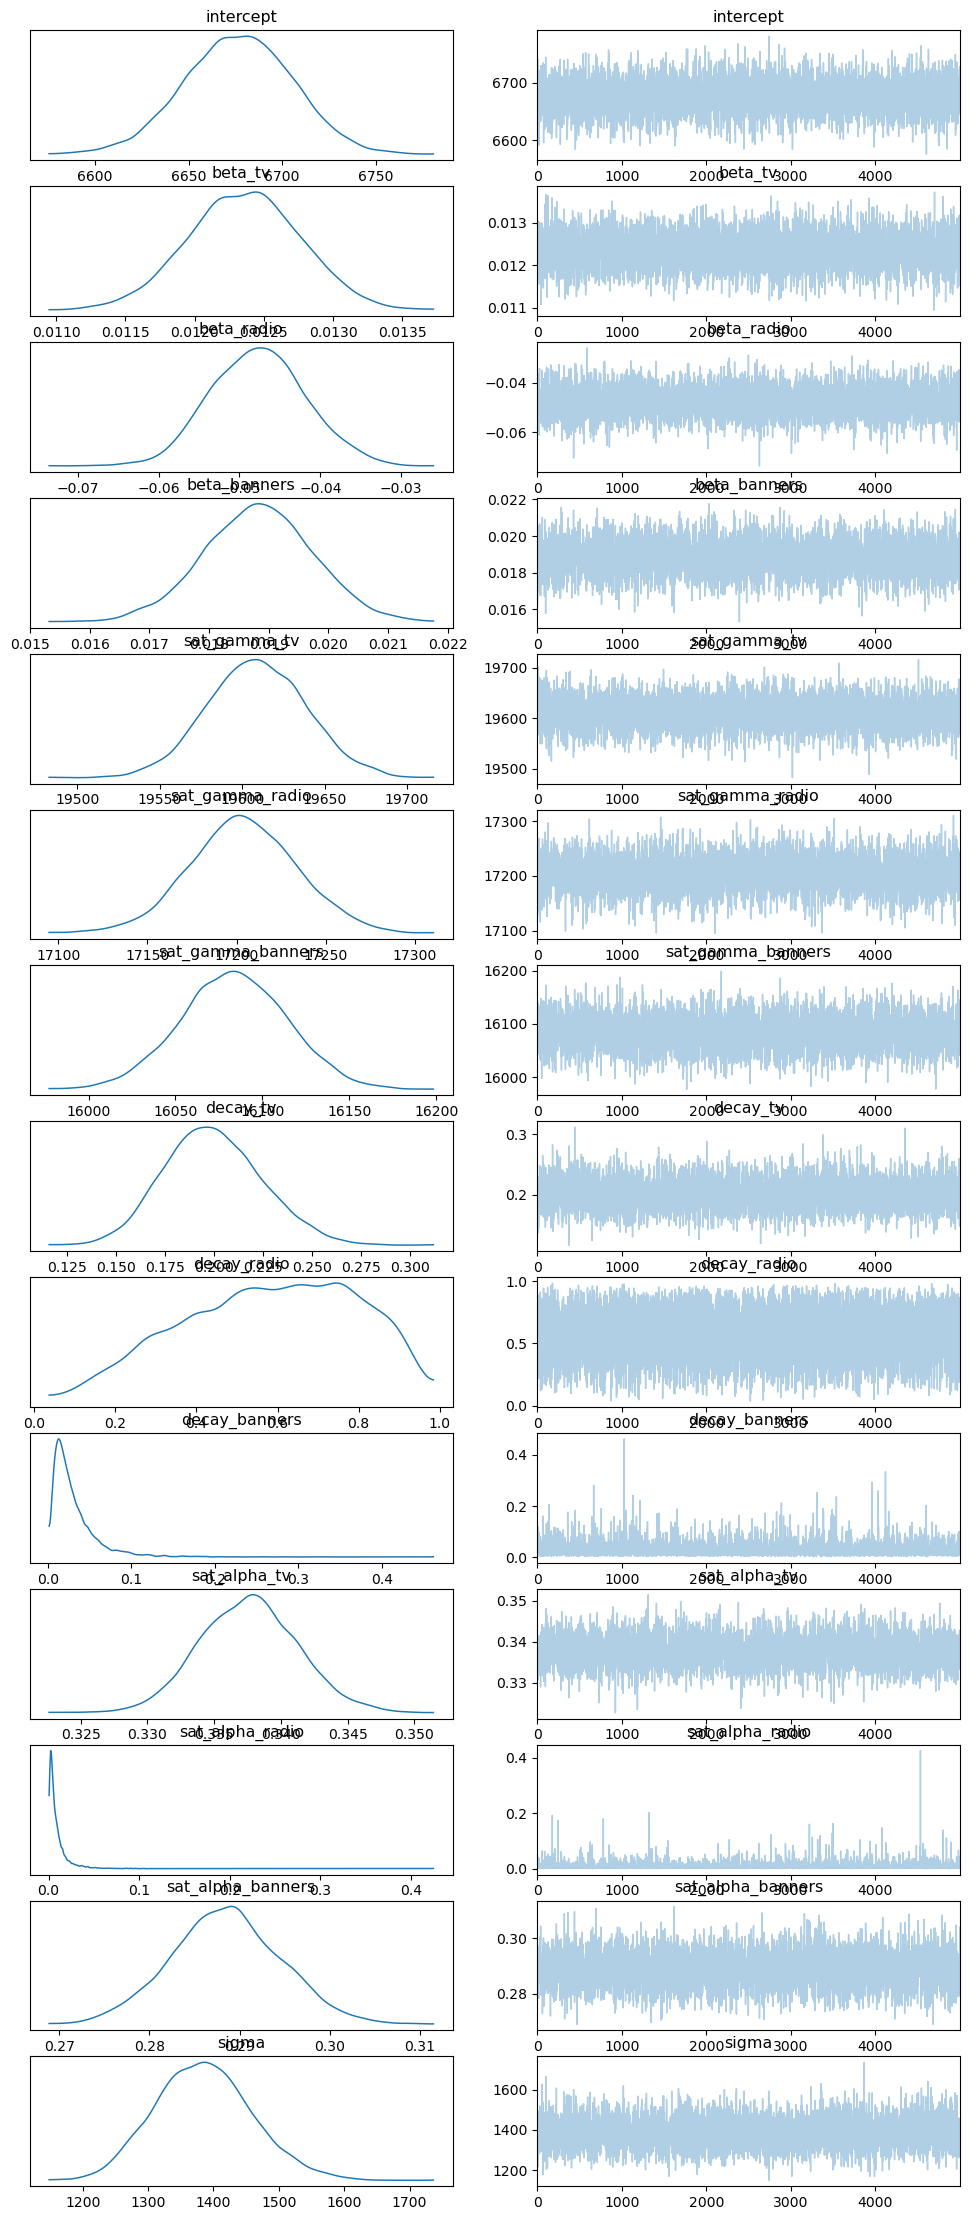

In [126]:
az.plot_trace(trace_vi)
summary_df = az.summary(trace_vi)
print(summary_df)

#### 5) Visualize and Quantify Outputs

In [127]:
sales_predictions = ppc['posterior_predictive']["sales"]  # shape: (n_draws, n_observations)

In [128]:
# Compute summary statistics:
sales_pred_mean = sales_predictions.mean(dim='draw')
sales_pred_mean_np = sales_pred_mean[0].values

In [129]:
original_sales = data["Sales"].values

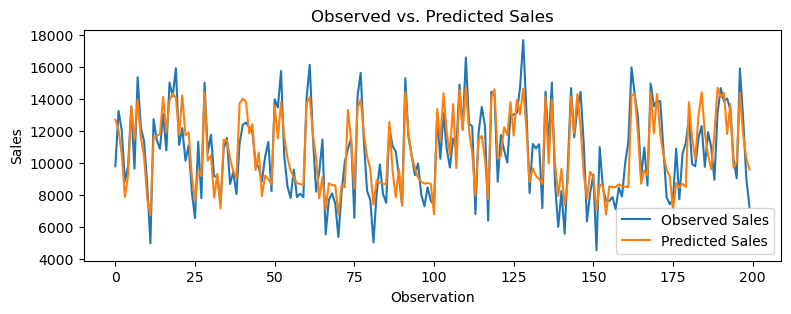

In [130]:
plt.figure(figsize=(9, 3))
plt.plot(original_sales, linestyle="-", label="Observed Sales")
plt.plot(sales_pred_mean_np, linestyle="-", label="Predicted Sales")
plt.xlabel("Observation")
plt.ylabel("Sales")
plt.title("Observed vs. Predicted Sales")
plt.legend()
plt.show()

In [131]:
# Store the model parameters
params = summary_df['mean']

# Extract means for model parameters
intercept_mean = float(params["intercept"])
beta_tv_mean = float(params["beta_tv"])
beta_radio_mean = float(params["beta_radio"])
beta_banners_mean = float(params["beta_banners"])

decay_tv_mean = float(params["decay_tv"])
decay_radio_mean = float(params["decay_radio"])
decay_banners_mean = float(params["decay_banners"])

sat_alpha_tv_mean = float(params["sat_alpha_tv"])
sat_alpha_radio_mean = float(params["sat_alpha_radio"])
sat_alpha_banners_mean = float(params["sat_alpha_banners"])

sat_gamma_tv_mean = float(params["sat_gamma_tv"])
sat_gamma_radio_mean = float(params["sat_gamma_radio"])
sat_gamma_banners_mean = float(params["sat_gamma_banners"])

In [132]:
# Compute channel effects using the mean parameter values
tv_spend = data["TV"].values.astype("float64")
radio_spend = data["Radio"].values.astype("float64")
banners_spend = data["Banners"].values.astype("float64")

# Compute adstock-transformed spend for each channel
tv_adstock = function([],adstock(tv_spend, decay_tv_mean))()
radio_adstock = function([],adstock(radio_spend, decay_radio_mean))()
banners_adstock = function([],adstock(banners_spend, decay_banners_mean))()

# Apply the saturation transformation (power_func) to get the channel effect.
tv_effect = power_func(tv_adstock, sat_alpha_tv_mean, sat_gamma_tv_mean)
radio_effect = power_func(radio_adstock, sat_alpha_radio_mean, sat_gamma_radio_mean)
banners_effect = power_func(banners_adstock, sat_alpha_banners_mean, sat_gamma_banners_mean)

In [133]:
# Compute the incremental contribution from each media channel:
tv_contribution = beta_tv_mean * tv_effect
radio_contribution = beta_radio_mean * radio_effect
banners_contribution = beta_banners_mean * banners_effect

In [134]:
# Compute overall predictions and incremental contribution
sales_pred_with_media = (intercept_mean +
                         tv_contribution +
                         radio_contribution +
                         banners_contribution)

In [135]:
# Baseline prediction (without media, i.e. only the intercept)
baseline_sales = intercept_mean*np.ones_like(sales_pred_with_media)

In [136]:
# Incremental media contribution:
incremental_media = sales_pred_with_media-baseline_sales

In [137]:
# Compute percentage incremental contribution:
percentage_incremental = incremental_media / sales_pred_with_media * 100

In [138]:
# Now convert everything to numeric arrays
sales_pred_with_media_np = np.array(sales_pred_with_media, dtype=np.float64)
baseline_sales_np = np.array(baseline_sales, dtype=np.float64)
incremental_media_np = np.array(incremental_media, dtype=np.float64)
percentage_incremental_np = np.array(percentage_incremental, dtype=np.float64)

In [139]:
# Report the incrementality results
print("----- Incremental Contribution of Media to Sales -----")
print(f"Mean baseline sales (without media): {np.mean(baseline_sales):.0f}")
print(f"Mean predicted sales (with media): {np.mean(sales_pred_with_media):.0f}")
print(f"Mean incremental media contribution: {np.mean(incremental_media):.0f}")
print(f"Percentage incremental contribution: {np.mean(percentage_incremental):.1f}%")

----- Incremental Contribution of Media to Sales -----
Mean baseline sales (without media): 6677
Mean predicted sales (with media): 10703
Mean incremental media contribution: 4026
Percentage incremental contribution: 34.9%


In [140]:
# Report the breakout by channel
tv_mean = np.mean(tv_contribution)
radio_mean = np.mean(radio_contribution)
banners_mean = np.mean(banners_contribution)

# Compute each channel's percentage contribution relative to full predicted sales mean
overall_mean = np.mean(sales_pred_with_media_np)
tv_percent = tv_mean / overall_mean * 100
radio_percent = radio_mean / overall_mean * 100
banners_percent = banners_mean / overall_mean * 100

In [141]:
print("Breakout by channel:")
print(f"TV contribution: {tv_mean:.0f} ({tv_percent:.1f}%)")
print(f"Radio contribution: {radio_mean:.0f} ({radio_percent:.1f}%)")
print(f"Banners contribution: {banners_mean:.0f} ({banners_percent:.1f}%)")

Breakout by channel:
TV contribution: 2631 (24.6%)
Radio contribution: -893 (-8.3%)
Banners contribution: 2289 (21.4%)


#### 6) Summary and Conclusion

In this notebook, we developed and evaluated a Bayesian Media Mix Model (MMM) using PyMC. By incorporating adstock and saturation transformations for each channel (TV, Radio, and Banners), we derived estimates for how these media investments contribute incrementally to total Sales.

<h5>Overall Incremental Contribution of Paid Media</h5>
The model suggests that paid media collectively drove an incremental +34.9% of Sales over the baseline. When we break this down by channel:
<ul>
    <li><b>TV</b>: +24.6% of total Sales</li>
    <li><b>Radio</b>: -8.3% of total Sales</li>
    <li><b>TV</b>: +21.4% of total Sales</li>
</ul>
Notably, Radio’s estimated contribution was negative in this analysis.

<h5>Potential Reasons for a Negative Radio Contribution</h5>
<ol>
    <li><b>Model Specification</b>: It could be that the adstock or saturation specifications prevented the model from detecting a positive impact on Sales.  In future runs it would be good to test different priors and distributions for the transformations on Radio spend.</li>
    <li><b>Seasonality</b>: We did not control for seasonality in this model.  It's possible that the negative contributions attributed to Radio are part of a seasonal pattern that is not accounted for here.</li>
    <li><b>Genuinely Negative Impact</b>: It might just be the case that Radio is hurting Sales performance.  In our simple linear regression approach we see a very low coefficient for transformed Radio spend, which lends credibility to the notion that Radio is an underperforming channel.</li>
</ol>

<h5>Next Steps</h5>
<ul>
    <li><b>Refine Hyperparameters</b>: Revisit and adjust priors and hyperparameters (e.g., for decay and saturation) to allow for a broader range of dynamic responses</li>
    <li><b>Transformations</b>: Experiment with alternative functional forms (such as log, spline, or piecewise functions) to better capture non-linear media effects</li>
    <li><b>Seasonality</b>: Incorporate time-varying components or seasonal terms to account for recurring patterns and improve the fit to peaks and valleys.</li>
</ul>
While paid media in total showed a substantial contribution to Sales, the negative estimate for Radio warrants closer inspection of both the data and model assumptions. With further refinements and additional information, you can gain a clearer, more accurate picture of each channel’s true incremental impact.